# 2D Structure tensor -  a few examples

*Author: Vedrana Andersen Dahl (vand@dtu.dk), uses code by Niels Jeppesen.*

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/vedranaa/teaching-notebooks/blob/main/Orientations_2D_examples.ipynb)

A few examples of using structure tensor in 2D. The examples show different ways of visualizing the orientations, visualizing the distribution of orientations, and how parameter choices influence the orientationa analysis.

In [2]:
!pip install -q structure_tensor
import numpy as np
import skimage.io
import matplotlib.pyplot as plt 
import structure_tensor as st
import cmocean

In [16]:
def plot_orientations(ax, vec, s = 5):
    """ Helping function for adding orientation-quiver to the plot.
    Arguments: plot axes, image shape, orientation, arrow spacing.
    """
    dim = vec.shape[1:]
    xmesh, ymesh = np.meshgrid(np.arange(dim[0]), np.arange(dim[1]), indexing='ij')
    ax.quiver(ymesh[s//2::s,s//2::s],xmesh[s//2::s,s//2::s],vec[1, s//2::s,s//2::s],vec[0, s//2::s,s//2::s],color='r',angles='xy')
    ax.quiver(ymesh[s//2::s,s//2::s],xmesh[s//2::s,s//2::s],-vec[1, s//2::s,s//2::s],-vec[0, s//2::s,s//2::s],color='r',angles='xy')


def polar_histogram(ax, distribution, cmap = 'hsv'):
    """ Helping function for producing polar histogram.
    Arguments: plot axes, oriantation distribution, colormap.
    """
    N = distribution.size
    bin_centers_full = (np.arange(2*N)+0.5)*np.pi/N # full circle (360 deg)
    distribution_full = np.r_[distribution,distribution]/max(distribution) # full normalized distribution
    x = np.r_[distribution_full*np.cos(bin_centers_full),0]
    y = np.r_[distribution_full*np.sin(bin_centers_full),0]
    triangles = np.array([(i, np.mod(i-1,2*N), 2*N) for i in range(2*N)]) # triangles[0] is symmetric over 0 degree
    triangle_centers_full = (np.arange(2*N))*np.pi/N # a triangle covers area BETWEEN two bin_centers
    triangle_colors = np.mod(triangle_centers_full, np.pi)/np.pi # from 0 to 1-(1/2N)
    ax.tripcolor(y, x, triangles, facecolors=triangle_colors, cmap=cmap, vmin = 0.0, vmax = 1.0)
    ax.set_aspect('equal')
    ax.set_xlim([-1,1])
    ax.set_ylim([1,-1]) 

## Example 1
Orientations computed from a simple test image, and visualized using orientation arrows or color. 

When visualizing predominant orientation information as color without the overlay of intensity image, it may seem as orientation changes abruptly in some areas. However, while the dominant orientation changes, the anisotropy is low in these areas. This means that transition from one orientation (ellipse elonagted in one direction) to another orientation (ellipse elongated in another directrion) is over an isotropy (a circle). Therefore, the full orientation information (dominant orientation and anisotropy) is actually changing smoothly in these areas. 

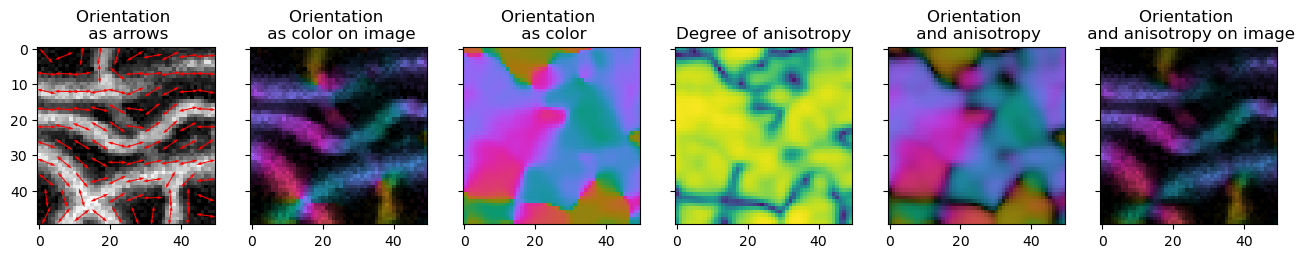

In [19]:
!wget 'https://lab.compute.dtu.dk/QIM/tutorials/structuretensor/-/raw/master/example_data_2D/drawn_fibres_B.png' -q
filename = 'drawn_fibres_B.png';
sigma = 0.5
rho = 2

image = skimage.io.imread(filename).astype(float)/255
S = st.structure_tensor_2d(image, sigma, rho)
val, vec = st.eig_special_2d(S)
cmap = cmap=cmocean.cm.phase

# visualization
figsize = (16,8)
fig, ax = plt.subplots(1, 6, figsize=figsize, sharex=True, sharey=True)
ax[0].imshow(image, cmap=plt.cm.gray)
plot_orientations(ax[0], vec)
ax[0].set_title('Orientation \n as arrows')
#orientation_st_rgba = plt.cm.hsv((np.arctan2(vec[1], vec[0]) / np.pi))
orientation_st_rgba = cmap((np.arctan2(vec[1], vec[0]) / np.pi))
ax[1].imshow(plt.cm.gray(image)*orientation_st_rgba)
ax[1].set_title('Orientation \n as color on image')
ax[2].imshow(orientation_st_rgba)
ax[2].set_title('Orientation \n as color')
anisotropy = (1-val[0]/val[1])
ax[3].imshow(anisotropy, cmap=plt.cm.viridis)
ax[3].set_title('Degree of anisotropy')
ax[4].imshow(plt.cm.gray(anisotropy)*orientation_st_rgba)
ax[4].set_title('Orientation \n and anisotropy')
ax[5].imshow(plt.cm.gray(image)*plt.cm.gray(anisotropy)*orientation_st_rgba)
ax[5].set_title('Orientation \n and anisotropy on image')
plt.show()    
 

## Example 2
Orientation analysis of a slice showing cardboard fibres. This example shows how orientation may be collected and shown as a histogram over angles or as a polar histogram. 

These histograms collect the orientation information for the whole image. However, as shown above, the orientation information is reliable only in areas of high anisotropy. For this reason, and depending on problem at hand, it may be desirable to weigh the orientations using the anisotropy (remove parts with low anisotropy) or the intensity (remove the background and keep only the orientation of the fibres). 

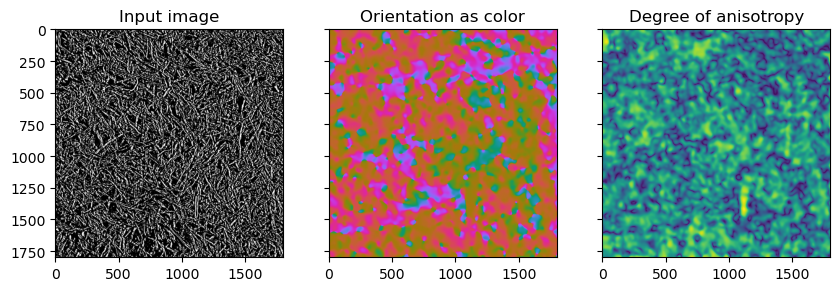

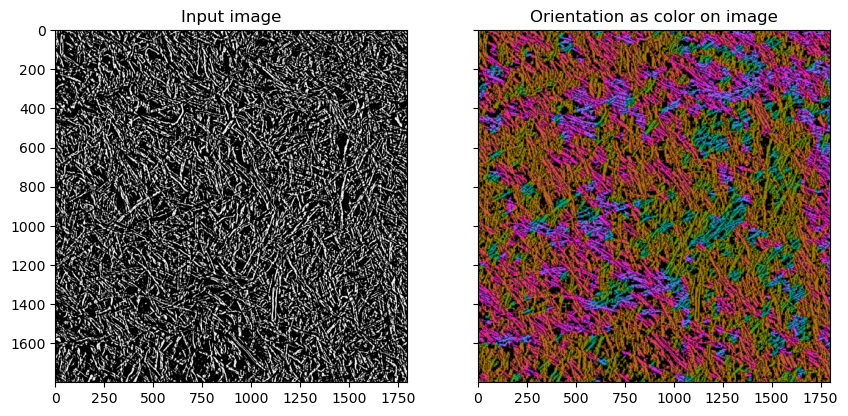

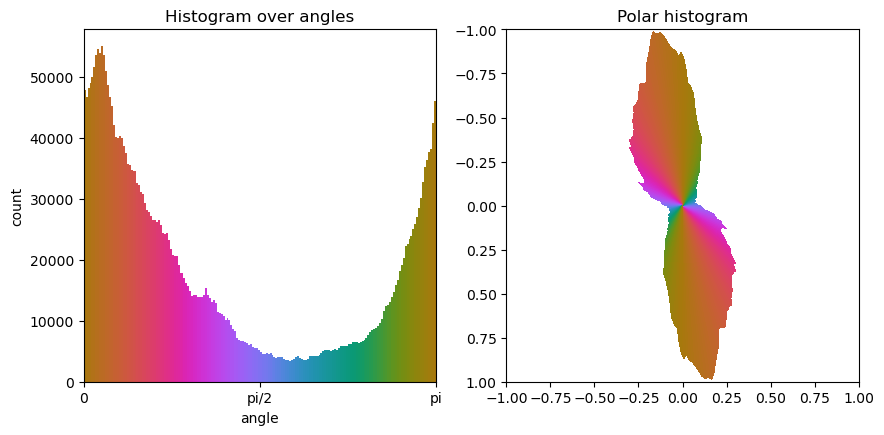

In [17]:
!wget 'https://lab.compute.dtu.dk/QIM/tutorials/structuretensor/-/raw/master/example_data_2D/10X.png' -q
filename = '10X.png';
sigma = 0.5
rho = 15
N = 180 # number of angle bins for orientation histogram

# computation
image = skimage.io.imread(filename)
image = np.mean(image[:,:,0:3],axis=2)
S = st.structure_tensor_2d(image, sigma, rho)
val,vec = st.eig_special_2d(S)
angles = np.arctan2(vec[1], vec[0]) # angles from 0 to pi
distribution = np.histogram(angles, bins=N, range=(0.0, np.pi))[0]
cmap = cmocean.cm.phase
    
# visualization
anisotropy = (1-val[0]/val[1])
figsize = (10,5)
fig, ax = plt.subplots(1, 3, figsize=figsize, sharex=True, sharey=True)
ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].set_title('Input image')
orientation_st_rgba = plt.cm.hsv((angles/np.pi))
orientation_st_rgba = cmap((angles/np.pi))
ax[1].imshow(orientation_st_rgba)
ax[1].set_title('Orientation as color')
ax[2].imshow(anisotropy, cmap=plt.cm.viridis)
ax[2].set_title('Degree of anisotropy')

fig, ax = plt.subplots(1, 2, figsize=figsize, sharex=True, sharey=True)
ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].set_title('Input image')
orientation_st_rgba = cmap((angles/np.pi))
ax[1].imshow(plt.cm.gray(image)*orientation_st_rgba)
ax[1].set_title('Orientation as color on image')

fig, ax = plt.subplots(1,2, figsize=figsize)
bin_centers = (np.arange(N)+0.5)*np.pi/N # halp circle (180 deg)
colors = cmap(bin_centers/np.pi)
ax[0].bar(bin_centers, distribution, width = np.pi/N, color = colors)
ax[0].set_xlabel('angle')
ax[0].set_xlim([0,np.pi])
ax[0].set_aspect(np.pi/ax[0].get_ylim()[1])
ax[0].set_xticks([0,np.pi/2,np.pi])
ax[0].set_xticklabels(['0','pi/2','pi'])
ax[0].set_ylabel('count')
ax[0].set_title('Histogram over angles')
polar_histogram(ax[1], distribution, cmap = cmap)
ax[1].set_title('Polar histogram')
plt.show()


## OCT example
A example of computing orientation information from the OCT image of a retina.

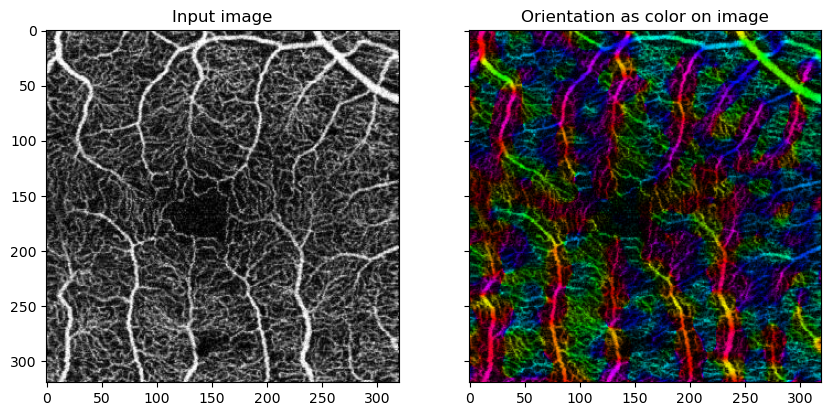

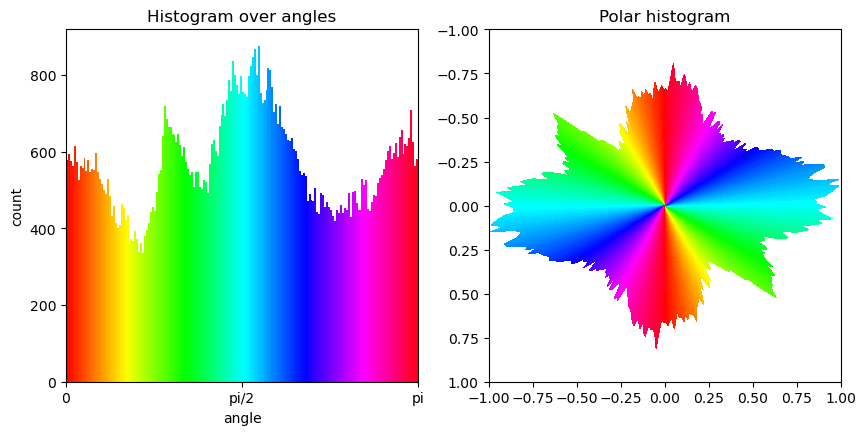

In [5]:
!wget 'https://lab.compute.dtu.dk/QIM/tutorials/structuretensor/-/raw/master/example_data_2D/oct_im_org.png' -q
filename = 'oct_im_org.png';
sigma = 0.5
rho = 5
N = 180 # number of angle bins for orientation histogram

# computation
image = skimage.io.imread(filename)
S = st.structure_tensor_2d(image.astype('float'), sigma, rho)
val, vec = st.eig_special_2d(S)
angles = np.arctan2(vec[1], vec[0]) # angles from 0 to pi
distribution = np.histogram(angles, bins=N, range=(0.0, np.pi))[0]
    
# visualization
figsize = (10,5)
fig, ax = plt.subplots(1, 2, figsize=figsize, sharex=True, sharey=True)
ax[0].imshow(image,cmap=plt.cm.gray)
ax[0].set_title('Input image')
orientation_st_rgba = plt.cm.hsv((angles/np.pi))
ax[1].imshow(plt.cm.gray(image)*orientation_st_rgba)
ax[1].set_title('Orientation as color on image')

fig, ax = plt.subplots(1,2, figsize=figsize)
bin_centers = (np.arange(N)+0.5)*np.pi/N # halp circle (180 deg)
colors = plt.cm.hsv(bin_centers/np.pi)
ax[0].bar(bin_centers, distribution, width = np.pi/N, color = colors)
ax[0].set_xlabel('angle')
ax[0].set_xlim([0,np.pi])
ax[0].set_aspect(np.pi/ax[0].get_ylim()[1])
ax[0].set_xticks([0,np.pi/2,np.pi])
ax[0].set_xticklabels(['0','pi/2','pi'])
ax[0].set_ylabel('count')
ax[0].set_title('Histogram over angles')
polar_histogram(ax[1], distribution)
ax[1].set_title('Polar histogram')
plt.show()

## Investigating the effect of integration size rho
Integration size rho is a crucial parameter when working with structure tensor, and especially if ofientation information is to be sampled om the image. This example shows how small rho captures the randomness of the individual fibre, and equidistantly placed orientation arrows will appear random. Larger rho captures the orientation on a larger scale, and flow appears smoother. 

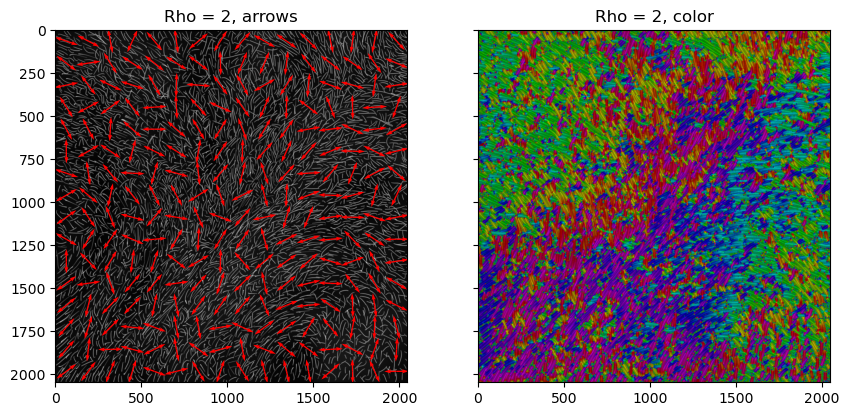

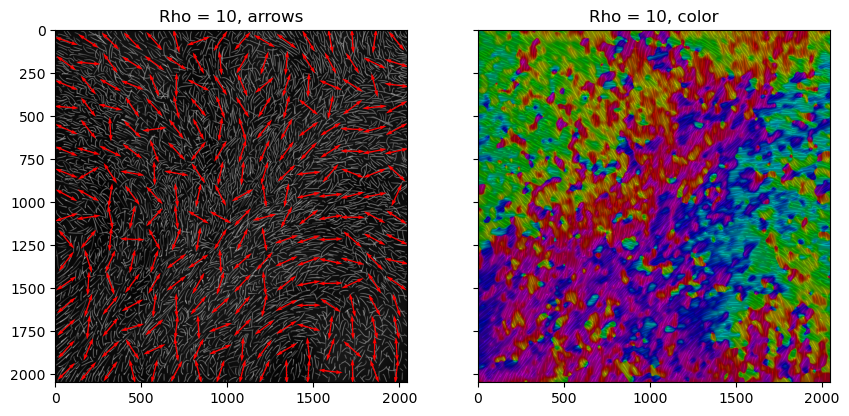

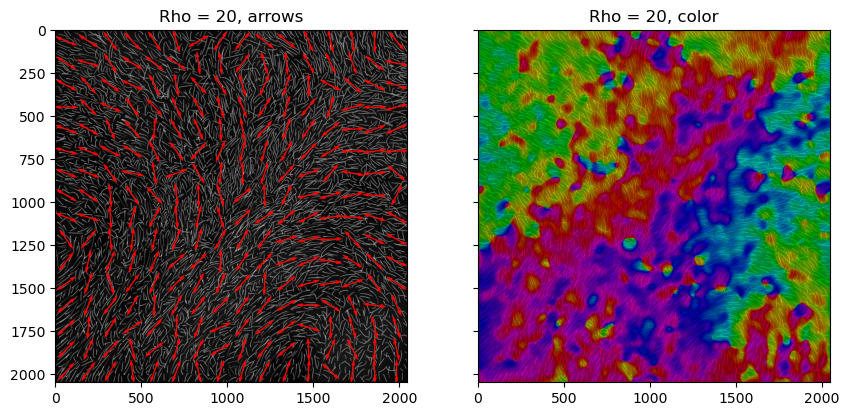

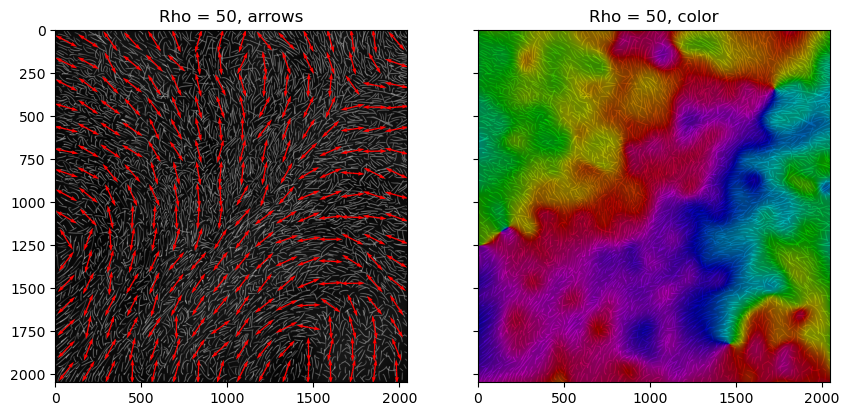

In [6]:
!wget 'https://lab.compute.dtu.dk/QIM/tutorials/structuretensor/-/raw/master/example_data_2D/short_fibres.png' -q
filename = 'short_fibres.png'
image = skimage.io.imread(filename)
image = np.mean(image[:,:,0:3],axis=2)
image -= np.min(image)
image /= np.max(image)

s = 128 # quiver arrow spacing
sigma = 0.5
figsize = (10,5)

rhos = [2,10,20,50]

for k in range(4):
    
    # computation
    rho = rhos[k] # changing integration radius
    S = st.structure_tensor_2d(image,sigma,rho)
    val, vec = st.eig_special_2d(S)
        
    # visualization
    fig, ax = plt.subplots(1, 2, figsize=figsize, sharex=True, sharey=True)
    ax[0].imshow(image,cmap=plt.cm.gray)
    plot_orientations(ax[0], vec, s = s)
    ax[0].set_title(f'Rho = {rho}, arrows')
    intensity_rgba = plt.cm.gray(image)
    orientation_st_rgba = plt.cm.hsv((np.arctan2(vec[1], vec[0])/np.pi))
    ax[1].imshow((0.5+0.5*intensity_rgba)*orientation_st_rgba)
    ax[1].set_title(f'Rho = {rho}, color')

    plt.show()

## Investigating the effect of downsampling
This example demonstrates the robustness of structure tensor to downsampling. At the highest resolution, individual fibres can be distinguished, and large a large rho is used to capture a smooth flow. At smaller resolutions, individual fibres cannot be distinguished, but the orientation information, now using a smaller rho, is still rather stable.

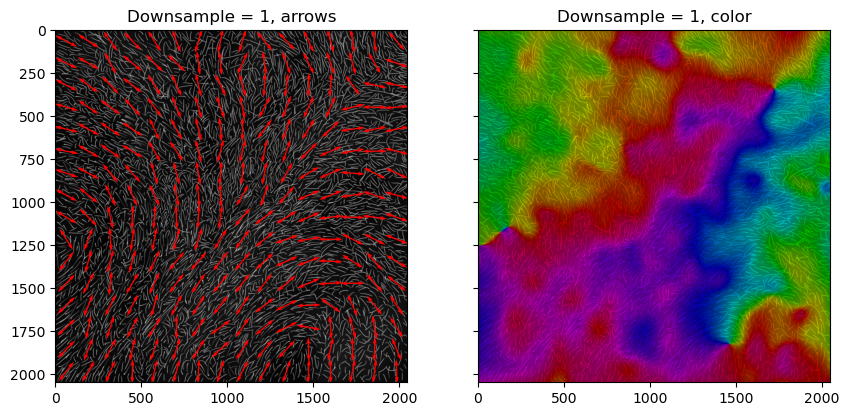

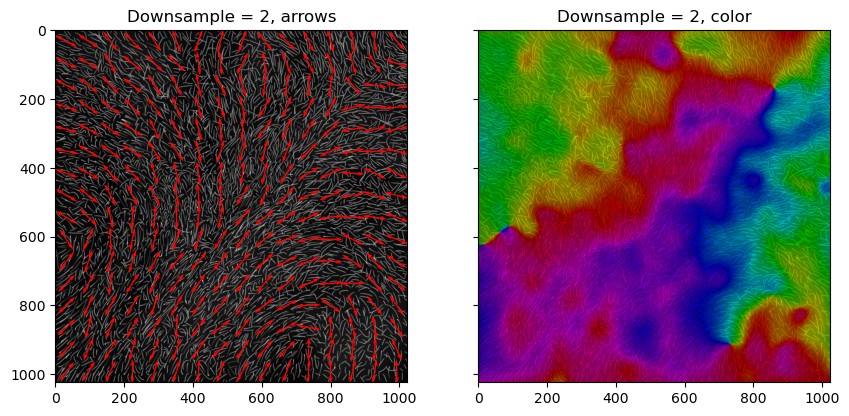

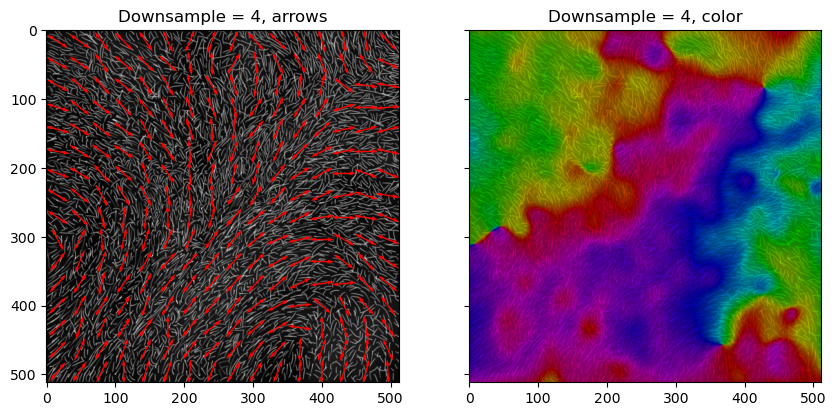

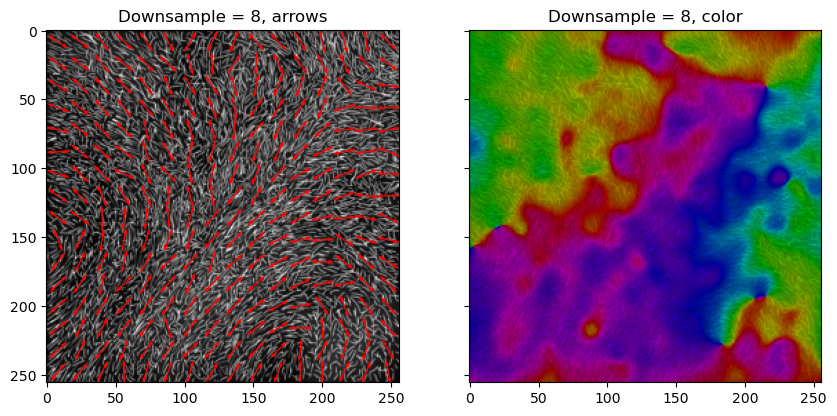

In [7]:
import skimage.transform

original_image = image.copy()
downsampling_range = 4
figsize = (10,5)    

for k in range(downsampling_range):

    # downsampling and computation
    scale = 2**k
    f = 1/scale # image scale factor
    s = 128//scale # quiver arrow spacing
    sigma = 0.5 # would it make sense to scale this too?
    rho = 50/scale # scaling the integration radius
    image = skimage.transform.rescale(original_image, f)
    S = st.structure_tensor_2d(image,sigma,rho)
    val, vec = st.eig_special_2d(S)
        
    # visualization
    fig, ax = plt.subplots(1, 2, figsize=figsize, sharex=True, sharey=True)
    ax[0].imshow(image,cmap=plt.cm.gray)
    plot_orientations(ax[0], vec, s = s)
    ax[0].set_title(f'Downsample = {scale}, arrows')
    intensity_rgba = plt.cm.gray(image)
    orientation_st_rgba = plt.cm.hsv((np.arctan2(vec[1], vec[0])/np.pi))
    ax[1].imshow((0.5+0.5*intensity_rgba)*orientation_st_rgba)       
    ax[1].set_title(f'Downsample = {scale}, color')
 
    plt.show()